# 基于编解码框架的生成服装描述的网络

## 曾丞至 2021213624

本实验的目标是设计一个神经网络用于生成服装图片的描述。

使用的实验数据是约12000张deepfashion-multimodel的图片数据集，其中约10000张用于训练，2000张用于测试。还有两个json文件，存储图片对应描述

实验环境:jupyter notebook,使用rtx 2060训练

实验的流程如下：

1.处理数据。首先将train_captions.json和test_captions.json中出现的所有单词统计出来，并加上起始符、终止符、pad、unknown。并将他们作为键，生成数字作为值，以json文件存下来，作为词表文件。然后再创建数据集类，继承自torch的Dateset类，用于将训练和测试所用的图片转换成张量，给出对应的描述等，在训练时加载到torch的Dataloader类中，规范训练的流程。

2.构建神经网络。选择网络的编码器和解码器，并根据任务需求和输入输出的格式做调整，整合进一个大网络中，写forward函数用于训练，再额外编写一个预测用的函数。

3.编写训练、测试以及其他的一些函数，规范化整个训练流程

## 详细说明会在对应的代码块上方给出
-----------------

一共有12000多张图片，每张图片image对应一个句子caption

json文件的键值对就是图片名+对应的句子，train有10000张，test有2000张

第一步就是先构建词表，每个词对应的数字编码，保存下来

词表只需构建一次，后续的任务直接读取存储下来的json文件就行

将这个功能封装成函数，只有第一次运行要调用，后面都是注释掉不用的

In [1]:
import json
from collections import Counter
import os

def create_vocab(dataset='deepfashion-multimodal',min_word_count=5):

    test_json_path='./data/%s/test_captions.json' % dataset
    image_folder='./data/%s/images' % dataset
    output_folder='./data/%s' % dataset

    with open(test_json_path, 'r') as j:
        data = json.load(j)
    vocab = Counter()
    for k in data.keys():
        caption=data[k]
        word_lists=caption.split()
        vocab.update(word_lists)
    
    print(len(vocab))
    
    # 创建词典，增加占位标识符<pad>、未登录词标识符<unk>、句子首尾标识符<start>和<end>
    #这个vocab是给每个词一个value，用来编码，如：dog：31，编码方式仅仅是词数组的顺序
    #去掉出现频率小于5的词
    words = [w for w in vocab.keys() if vocab[w] > min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0                              
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)
    print(len(vocab))

    # 存储词典
    with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw)

#create_vocab()

创建数据集类，继承自Dataset，重写__getitem函数__

数据集类接受5个参数，图片文件夹的路径，caption的json文件路径，词表json文件路径，描述的句子最大长度，以及transform，用来将图片转成张量

在init函数中，首先会将caption文件加载进来，并存储里面的数据。caption文件存储的方式是键值对，键是图片的名称，以jpg结尾，值是对应的描述。键加上图片文件夹程序就能找到这张图片。描述是字符串，用split函数将其变成列表，每个元素是一个单词，然后用词表文件映射成数字，一个句子就变成了一堆数字。

在getitem函数中，首先将文件夹和图片名连接在一起，用Image类打开，然后用transform从PIL格式转换成张量，再拿到对应的描述(一堆数据，如果长度不够，则补pad)同时也会记录pad的位置，并返回。一同返回的有图片的张量，描述的输入(首字符是起始符),目标的输出(结尾是终止符),图像的路径。之所以这么返回是因为后续训练的需求。

In [2]:
import numpy as np
import os
import json
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader

class ImageTextDataset(Dataset):
    """
    PyTorch数据类，用于PyTorch DataLoader来按批次产生数据
    """

    def __init__(self, images_path, captions_path ,vocab_path, max_len=50, transform=None):
        """
        参数：
            images_path：图片文件夹路径
            captions_path：描述句子json文件路径
            vocab_path：词典json文件路径
            max_len：文本描述包含的最大单词数
            transform: 图像预处理方法
        """
        self.data=[]
        self.max_len = max_len
        self.images_path=images_path
        # 载入数据集
        with open(captions_path, 'r') as f:
            self.captions = json.load(f)
        # 载入词典
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        for index, key in enumerate(self.captions):
            value=self.captions[key].split()           #['a','women','is','wearing',...]
            #如果描述的句子太长，自动截断
            if(len(value)>max_len):
                value=value[:max_len]
            value=[self.vocab['<start>']]+[self.vocab.get(word, self.vocab['<unk>']) for word in value]+[self.vocab['<end>']]
            self.data.append([key,value])

        # PyTorch图像预处理流程
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.data)

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        image_file_path=os.path.join(self.images_path, self.data[i][0])
        img = Image.open(image_file_path).convert('RGB')

        if self.transform is not None:
            img_tensor = self.transform(img)

        caplen = len(self.data[i][1])
        #在dataloader中，拿到的最长长度是maxlen+2，因为加了起始符和终止符
        #self.max_len + 3 - caplen是因为maxlen+2减去caplen-1
        target_caption=torch.LongTensor(self.data[i][1][1:]+ [self.vocab['<pad>']] * (self.max_len + 3 - caplen))
        input_caption=torch.LongTensor(self.data[i][1][:-1]+ [self.vocab['<pad>']] * (self.max_len + 3 - caplen))
        
        tgt_padding_mask = torch.ones([self.max_len+2, ])
        tgt_padding_mask[:caplen-1] = 0.0
        tgt_padding_mask = tgt_padding_mask.bool()
        
        return img_tensor, input_caption, target_caption,tgt_padding_mask,image_file_path
        

    def __len__(self):
        return self.dataset_size

train_tx = transforms.Compose([
        #transforms.Resize((1100,750)),
        transforms.Resize((1000,700)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_tx = transforms.Compose([
        #transforms.Resize((1100,750)),
        transforms.Resize((1000,700)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

## 图像编码器

直接使用pytorch训练好的res101

## 解码器模块

解码器使用最朴素的Transformer，pytorch自带的只有TransformerDecoder和TransformerDecoderLayer，其余的残差快和位置编码需要自己编写

声明一个Decoder类继承自nn.Module，这个类init接受的参数有词表，词在网络的维度，深度，多头注意力的头数，前馈神经网络的中间神经元维度，drop层的drop率，描述句子的最大长度，编码器输出的图像特征图的维度。init函数就是用于初始化这个解码器的一些参数，embed层，残差层，位置编码层等等，最后还有一个线性层将词向量降维，维度变成词表大小，用于分类和训练。

Decoder的forward函数，也就是工作流程是：首先把编码器给的图片特征图降维，因为Transformer的解码器是做交叉注意力，图片特征图的维度必须和词向量维度相同。然后过一个激活函数。输入的描述，也就是ground-truth进来则需要过embed层，因为每个词目前仅仅由一个数字表示，要将这个数字编程一个高维向量，然后过一个激活函数，并加上位置编码。两个输入都处理完毕后就可以直接丢给TransformerDecoder，一同丢进去的还有别的两个参数，用于表明一个句子中那些位置不是pad，以及一个句子中某个位置能看到的别的位置，这些是Transformer自己的特性。

In [3]:
import torch.nn.functional as F
from torch.nn import TransformerDecoderLayer, TransformerDecoder
import json

class ResidualBlock(nn.Module):
    """残差块"""

    def __init__(self, input_dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(),
            nn.Linear(input_dim, input_dim),
        )

    def forward(self, x):
        """本体加上两个线性变化"""
        skip_connection = x
        x = self.block(x)
        x = skip_connection + x
        return x

class PositionalEncodings(nn.Module):
    """原始的位置编码"""

    def __init__(self, seq_len, d_model, p_dropout):
        super(PositionalEncodings, self).__init__()
        #[[0],[1],[2],[3],...,[9]],shape=(10,1)
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        #[[0,1,2,...,99]],shape=(1,100)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (10000 ** ((2 * dim_positions) / d_model))
        #angles.shape=(10,100)

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])    #偶数位置用cos编码
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])  #奇数位置用sin编码
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        x = x + self.positional_encodings
        x = self.dropout(x)
        return x   
 
class Decoder(nn.Module):
    def __init__(self,vocab:dict,word_dim:int=512,depth:int=6,att_head:int=8,
                 ff_dim:int=1024,drop:int=0.5,max_len:int=50,img_feat_channels:int=2048
                 ) -> None:
        super(Decoder,self).__init__()

        self.vocab_size=len(vocab)

        #将每个词映射到一个高维度表示
        self.embedding_layer=nn.Embedding(self.vocab_size,word_dim)
        self.res_block = ResidualBlock(word_dim)
        #给每个词加上位置编码
        self.positional_encodings = PositionalEncodings(max_len+2, word_dim, drop)

        #将图片的维度降到和词的维度相同
        self.entry_mapping_img = nn.Linear(img_feat_channels, word_dim)
        
        transformer_decoder_layer = TransformerDecoderLayer(
            d_model=word_dim,
            nhead=att_head,
            dim_feedforward=ff_dim,
            dropout=drop,
            batch_first=True
        )
        self.decoder = TransformerDecoder(transformer_decoder_layer, depth)     #depth:transformer中有一个DecoderLayer
        
        #将高维word表示映射回字典大小维度，最大值索引就是对应的词
        #为何最后的线性映射只用一个linear?
        #因为transformer每个decoderLayer最后自带forwardfeed，也就是说在最终输出前已经经过线性层升维+激活+dropout+线性层降维
        self.classifier = nn.Linear(word_dim, self.vocab_size)

    def forward(self, x, image_features, tgt_padding_mask=None, tgt_mask=None):
        '''
        解码器工作流程：
        1.接受编码器给的(batch, H*W, C)的张量后,先把C降维到word_dim,用来做cross-attention,再做一次激活
        2.x是训练时的输入,也就是ground_truth,shape=(batch,max_len+2),不过第0个元素是起始符,最后一个元素是pad
        3.用embeddingLayer将每个词映射到高维度中,也就是(batch,max_len+2,word_dim)
        4.将这个映射后的输入经过激活+残差连接
        5.将处理过的输入再加入位置编码
        6.有了图片的表示和输入的表示就可以直接丢给pytorch定义好的transformerDecoder
        7.还要把padding_mask和tgt_mask穿进去
        8.经过decoder后的输出仍是(batch,maxlen+2,word_dim),用一个线性变换将word_dim映射到vocab_size维,最大的值对应的索引就是预测词
        '''
        #输入进来的image_feature已经被拉平了，是(batch,HW,C)
        image_features = self.entry_mapping_img(image_features)
        image_features = F.leaky_relu(image_features)

        x = self.embedding_layer(x)
        x = F.leaky_relu(x)

        x = self.res_block(x)
        x = F.leaky_relu(x)

        x = self.positional_encodings(x)

        x = self.decoder(
            tgt=x,
            memory=image_features,
            tgt_key_padding_mask=tgt_padding_mask,
            tgt_mask=tgt_mask
        )

        x = self.classifier(x)
        return x


整个模型由编码器和解码器组成，额外定义了一个函数用于接受一张图片，输出一个描述的句子

这个函数是通过for循环句子的最大长度实现的，考虑模型训练时是使用ground-truth，也就是说后面的看到前面的必须得是正确的

如果一次性将整个啥都不是的句子丢给transformer，预测的结果可能不好

因此通过for循环，先预测第一个单词，然后再到第二个单词在看第一个单词的基础上预测，后面的以此类推

In [4]:
from torchvision.models import resnet101,ResNet101_Weights

class Image_Caption_Generator(nn.Module):
    def __init__(self,vocab_path:str,max_len:int=50,word_dim:int=512) -> None:
        super(Image_Caption_Generator,self).__init__()
        with open(vocab_path, 'r') as f:
            self.vocab=json.load(f)
        self.vocab_size=len(self.vocab)
        self.max_len=max_len

        encoder=resnet101(weights=ResNet101_Weights.DEFAULT)
        encoder=torch.nn.Sequential(*list(encoder.children())[:-2])
        for param in encoder.parameters():
            param.requires_grad = False
        #图像编码器
        self.encoder=encoder
        #res101出来的特征图channels是2048

        #图像解码器
        self.decoder=Decoder(self.vocab,word_dim=word_dim,max_len=self.max_len)

    def forward(self,imgs,input_captions,tgt_padding_mask):
        with torch.no_grad():   #编码的前向传播不需要计算梯度
            output=self.encoder(imgs)
            #将图像的宽高拉成一条直线
            img_features = output.view(output.size(0), output.size(1), -1)
            #转换位置，让最后一维表示每个像素的维度
            img_features = img_features.permute(0, 2, 1)
            img_features = img_features.detach()

        tgt_mask=nn.Transformer.generate_square_subsequent_mask(self.max_len+2).to('cuda')
        preds=self.decoder(input_captions,img_features,tgt_padding_mask=tgt_padding_mask,tgt_mask=tgt_mask)
        return preds    #(batch,max_len+2,vocab_size)
    
    def generate_caption(self,image):
        assert len(image.shape)==4,'输入的图片张量应该是4维的'
        batch_size=image.size(0)
        device=image.device
        captions_list=[]                        #存所有图片对应的字符串

        image_feature=self.encoder(image)
        image_feature = image_feature.view(image_feature.size(0), image_feature.size(1), -1)
        image_feature = image_feature.permute(0, 2, 1)
        image_feature = image_feature.detach()

        input = torch.Tensor([self.vocab['<start>']] + [self.vocab['<pad>']] * (self.max_len+1)).to(device).long()
        input = input.repeat(batch_size, 1)
        padd_mask = torch.Tensor([True] * (self.max_len+2)).to(device).bool()
        padd_mask = padd_mask.repeat(batch_size, 1)

        is_decoded = [False] * batch_size       #batch中每项是否解码完成
        generated_captions = []                 #整个batch的结果
        for _ in range(batch_size):
            generated_captions.append([])

        tgt_mask=nn.Transformer.generate_square_subsequent_mask(self.max_len+2).to(device)

        for i in range(self.max_len+1):
            padd_mask[:,i]=False                #每次
            pred=self.decoder(input,image_feature,padd_mask,tgt_mask=tgt_mask)  #输出是(batch_size,max_len+2,vocab_size)
            #对batch做for循环，检查每个图片生成的句子的最新的单词
            for b in range(batch_size):                 #遍历每张图片对应的描述
                if(is_decoded[b]==True):
                    continue
                word_num=pred[b,i].topk(1)[1].item()      #取得当前位置最有可能的词的代号
                
                if(word_num==self.vocab['<end>']):    #如果是结束符，那就标记结束
                    is_decoded[b]=True
                    padd_mask[b,i]=False
                else:                                       #如果不是,将新词加进结尾，并且输入的下一个词变成新词
                    generated_captions[b].append(word_num)
                    input[b,i+1]=word_num
            if np.all(is_decoded):
                break
                
        #将数字转成词
        for output in generated_captions:
            output=[list(self.vocab.keys())[list(self.vocab.values()).index(n)] for n in output]
            captions_list.append(' '.join(output))
        return captions_list

def cut_caption(caption):
    '''
    因为网络训练的数据是减掉了max_Len后面的句子,因此网络经过训练后输出的也是“减掉”的句子
    为了美观，手动将最后一个句号后面的东西丢掉
    '''
    cap_len=len(caption)
    for i in range(cap_len-1,-1,-1):
        if(caption[i]=='.'):
            return caption[:i+1]

一些参数配置，以及将数据集加载进来

In [5]:
from argparse import Namespace 
config = Namespace(
    max_len = 50,           #描述最大长度
    batch_size = 16,        #训练每次传进去图片的数量
    image_code_dim = 2048,  #图片经过encoder，在decoder之前的维度
    word_dim = 512,         #词经过embedding层后的维度，也是图片要降成的维度
    decoderLayer_num=6,     #transformer中decoderLayer的个数
    head_num=8,             #多头机制的头数
    feedforward_dim=1024,   #transformer中前馈网络神经元的维度
    drop=0.5,               #前馈网络drop率
    learning_rate = 0.0001, #学习率
    num_epochs = 10,        #训练的epoch数
    grad_clip = 5.0,        #要截断的梯度参数
    evaluate_step=200,      #训练时个epoch多少轮在测试集上评估一次
)
IMAGE_FOLDER='./data/deepfashion-multimodal/images'
TRAIN_CAPTIONS_PATH='./data/deepfashion-multimodal/train_captions.json'
TEST_CAPTIONS_PATH='./data/deepfashion-multimodal/test_captions.json'
VOCAB_PATH='./data/deepfashion-multimodal/vocab.json'
CHECKPOINT_PATH='./data/checkpoint.pt'
train_data=ImageTextDataset(IMAGE_FOLDER,TRAIN_CAPTIONS_PATH,VOCAB_PATH,max_len=config.max_len,transform=train_tx)
test_data=ImageTextDataset(IMAGE_FOLDER,TEST_CAPTIONS_PATH,VOCAB_PATH,max_len=config.max_len,transform=test_tx)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_data,batch_size=16,shuffle=False,pin_memory=True)

评测的几个函数

show函数，接受一个图片的路径，还有模型，模型就会预测这个图片的描述，用plt展示出来

calculate_meteor_score函数计算meteor指标。

test函数用来对模型做测试，将这个模型遍历一次测试集，计算meteor得分

In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from nltk.translate import meteor_score
unloader=transforms.ToPILImage()

def show(img_path,model):
    ''' 给任意一张图片的路径,输出图像和对应描述 '''
    img=Image.open(img_path)
    img_tensor=test_tx(img)
    img_tensor=img_tensor.unsqueeze(0)
    preds=model.generate_caption(img_tensor)
    caption=cut_caption(preds[0])
    plt.imshow(img)
    plt.title(caption)
    plt.show()

def calculate_meteor_score(reference_texts,generated_texts,batch_size):
    sum_score=0
    for i in range(batch_size):
        r=reference_texts[i]
        g=generated_texts[i]
        ''' 考虑到g是截断的,因此提供r的全长和截断长度'''
        length=len(g)
        meteor = meteor_score.meteor_score([r[:length].split(),r.split()], g.split())
        sum_score+=meteor
    return sum_score

def test(model:Image_Caption_Generator or None=None):
    total_score=0
    if(model is None):
        model=Image_Caption_Generator(VOCAB_PATH,config.max_len)
        model.decoder.eval()
        model.load_state_dict(torch.load(CHECKPOINT_PATH))
    device=next(model.parameters()).device
    for i,(imgs,input_captions,target_captions,tgt_padding_mask,paths) in enumerate(test_loader):
        batch_size=imgs.size(0)
        outputs=[]
        #预测出结果，并加入输出列表
        imgs=imgs.to(device)
        captions_list=model.generate_caption(imgs)
        for caption in captions_list:
            caption=cut_caption(caption)
            outputs.append(caption)
            
        paths=[path.replace(IMAGE_FOLDER+'\\','') for path in paths]

        #加载训练集字典，找到图片对应的描述
        with open(TEST_CAPTIONS_PATH,'r') as f:
            test_dict=json.load(f)
        reference_texts=[test_dict[path] for path in paths]
        #计算预测描述和目标描述得分
        score = calculate_meteor_score(reference_texts,outputs,batch_size)
        total_score+=score
    return total_score
#test()

训练模块

1.选用交叉熵损失 2.选用adam优化器

模型的编码器是不训练的，我直接用训练好的res101，只有解码器的参数要训练，学习率是0.0001

训练模块会用txt文件记录，在一个epoch中，每100个batch就会显示一次loss，每200个batch就会在测试集上计算meteor得分，保留最好的参数。

In [7]:
def train(epochs:int=5,lr:int=0.0001,ckpt_path:str or None=None):
    #设定设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    #初始化所有东西
    loss_func=nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
    model=Image_Caption_Generator(VOCAB_PATH,config.max_len)
    if(ckpt_path is not None):
        model.load_state_dict(torch.load(ckpt_path))
    model.encoder.eval()
    model.decoder.train()
    model.to(device)
    optim=torch.optim.Adam(model.decoder.parameters(),lr=lr)

    best_score=0.0
    print("开始训练")
    fw = open('./data/log.txt', 'w')

    #return
    for e in range(epochs):
        loss=0
        for i, (imgs,input_captions,target_captions,tgt_padding_mask,_) in enumerate(train_loader):
            
            optim.zero_grad()
            #将数据全部移动到gpu上
            imgs=imgs.to(device)
            input_captions=input_captions.to(device)
            target_captions=target_captions.to(device)
            tgt_padding_mask=tgt_padding_mask.to(device)
            
            #预测出结果
            preds=model(imgs,input_captions,tgt_padding_mask)
            
            tgt_padding_mask = torch.logical_not(tgt_padding_mask)
            preds = preds[tgt_padding_mask]         
            #从preds中选出不为pad的位置，顺便shape从3维降成了2维，(？,vocab_size)问号取决于mask
            #同理从目标句子选出不为pad的位置，shape从2维降成1维,(?)，每个值应该在区间[0,vocab_size]之间
            target_captions= target_captions[tgt_padding_mask]

            loss = loss_func(preds,target_captions)
            loss.backward()
            nn.utils.clip_grad_norm_(model.decoder.parameters(), config.grad_clip)
            optim.step()
            #每一百次记录一次损失
            if(i%100==99):
                print('epoch %d, step %d: loss=%.2f' % (e, i+1, loss.cpu()))
                fw.write('epoch %d, step %d: loss=%.2f \n' % (e, i+1, loss.cpu()))
                fw.flush()
            #每若干次在测试集上进行计算meteor指标并保存
            if(i%config.evaluate_step==(config.evaluate_step-1)):
                #torch.cuda.empty_cache()
                model.decoder.eval()
                this_score=test(model)
                model.decoder.train()
                if(best_score<this_score):
                    best_score=this_score
                    torch.save(model.state_dict(),CHECKPOINT_PATH)
                fw.write('Validation@epoch, %d, step, %d, meteor=%.2f\n' % 
                  (e, i+1, this_score))
                fw.flush()
                print('Validation@epoch, %d, step, %d, meteor=%.2f' % 
                    (e, i+1, this_score))
    fw.close()    
train()
#train(3,ckpt_path=CHECKPOINT_PATH)

开始训练
epoch 0, step 100: loss=3.03
epoch 0, step 200: loss=2.09
Validation@epoch, 0, step, 200, meteor=1327.11
epoch 0, step 300: loss=1.78
epoch 0, step 400: loss=1.79
Validation@epoch, 0, step, 400, meteor=1298.63
epoch 0, step 500: loss=1.64
epoch 0, step 600: loss=1.53
Validation@epoch, 0, step, 600, meteor=1269.06
epoch 1, step 100: loss=1.46
epoch 1, step 200: loss=1.43
Validation@epoch, 1, step, 200, meteor=1457.72
epoch 1, step 300: loss=1.36
epoch 1, step 400: loss=1.36
Validation@epoch, 1, step, 400, meteor=1249.01
epoch 1, step 500: loss=1.40
epoch 1, step 600: loss=1.32
Validation@epoch, 1, step, 600, meteor=1236.54
epoch 2, step 100: loss=1.38
epoch 2, step 200: loss=1.30
Validation@epoch, 2, step, 200, meteor=1382.97
epoch 2, step 300: loss=1.35
epoch 2, step 400: loss=1.29
Validation@epoch, 2, step, 400, meteor=1313.99
epoch 2, step 500: loss=1.29
epoch 2, step 600: loss=1.27
Validation@epoch, 2, step, 600, meteor=1350.73
epoch 3, step 100: loss=1.28
epoch 3, step 200: lo

## 实验结果展示与分析：

本实验的目标能够正确完成，所有的代码也能如所期望的执行。

训练模块我个人观察，训练100个batch，也就是1600张图，在GPU上约3分半，而在测试集上做一次测试，也就是2000，大约15分钟，因为训练时Transformer在生成描述可以认为是同时生成的，即一个句子的第一个和第十个单词可以一起生成，而我测试是一个一个按顺序生成，因此速度比较慢，但这也是改良过的，可以一个批次多张图片一起生成。

训练的结果从log来看，loss是整体降低的，不过最后降低的程度就越小，可以认为快收敛了，但meteor指标可以看到，后面的性能并没有提升，总在一个区间里跌宕，loss的计算是生成的50个词和输入的50个词做交叉熵，而meteor的计算是生成的50个词做裁剪后，和原句子(可能大于50个词)做计算，这可能是指标上不去的原因，另一个原因也可能是网络训练存在瓶颈，没办法生成很最近原句的描述。

用plt来展示，描述也是符合图片的。但是也仍存在瑕疵，我认为是Transformer的问题。Transformer也有很多论文提过，它的注意力机制需要再更大的数据集上才有优势，数据集较小可能就会过拟合。实际上我随便丢几张图进来看，有很多词语是高频出现的，比如graphic patterns，cotton fabric，而且形成了一种固定“短语”,例如cotton后面一定是fabric，可能就是fabric在生成的时候，对cotton的注意力分数太大了。

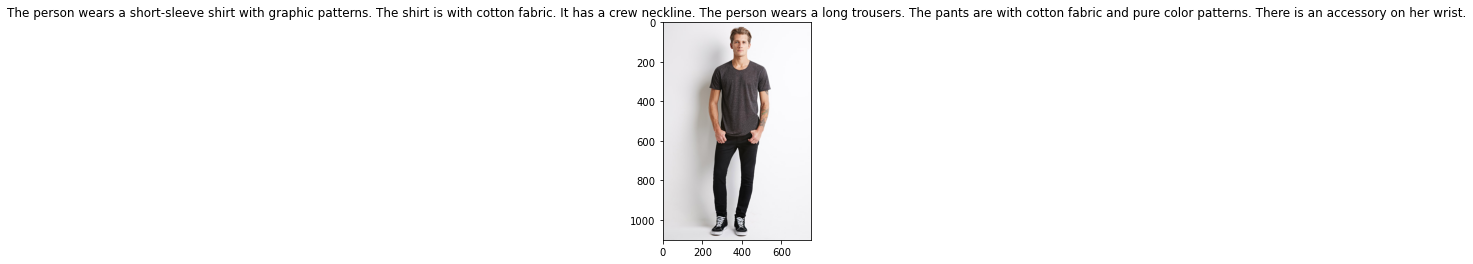

In [9]:
model=Image_Caption_Generator(VOCAB_PATH,config.max_len)
model.load_state_dict(torch.load(CHECKPOINT_PATH))
show('./data/deepfashion-multimodal/images/MEN-Denim-id_00000080-01_7_additional.jpg',model)

## 总结

本次的实验也算是完成任务，但略有不足。对我来说这是一个非常宝贵的经历，让我从头尝试过了一遍设计网络完成任务，因为选用了Transformer，我也上网查了很多有关Transformer的资料，加深了我对Transformer的理解，例如tgt_padding_mask，这玩意可以告诉Transformer哪些位置是pad，就不需要对这些位置计算了。数据集的构建也让我丰富了数据操作的经验。在实际应用这个网络的时候，我也发现这个网络效果并不完美，做了很多思考。总的来说我通过这个实验学到了很多。

In [8]:
#一些草稿代码
b=torch.logical_not(torch.tensor([[False,True],[False,False]]))
a=torch.tensor([[[0,0.1,0.2],[1,1.3,1.5]],[[2,2.4,2.6],[3,3.7,3.9]]])
c=torch.tensor([[1,0],[2,1]])
print(b)
print(c[b])
a[b]
#交叉熵损失函数可以自动将模型预测的vocab_Size维词向量和词对应数字编码做损失
#即pred=(batch,class_num),tgt=(batch),tgt每个元素的取值必须在0~class_num-1之间
#但交叉熵也比较反直觉，对于3维及以上的预测结果(batch,len,dim)和(batch,len),如果要丢进交叉熵里，得先将len和dim调换位置
loss_fcn = nn.CrossEntropyLoss(label_smoothing=0.1)
l=loss_fcn(a[b],c[b])
print(l)

tensor([[ True, False],
        [ True,  True]])
tensor([1, 2, 1])
tensor(1.0023)
